In [1]:
#supress warnings and make imports
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import pandas as pd
import nibabel as nib
import numpy as np
from nilearn.input_data import NiftiMasker
import scipy.io
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.svm import LinearSVC
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from brainiak.utils.fmrisim import _double_gamma_hrf as hrf_func
from brainiak.utils import fmrisim as sim

%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

/packages/miniconda/20190102/envs/brainiak-20221110/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


Autosaving every 5 seconds


In [2]:
# Load and perpare data for one subject
def load_fs_data(data_path, sub_id, mask=''):
    # find file path
    sub = 'sub-' + (sub_id)
    input_dir = os.path.join(data_path, sub)
    data_file = os.path.join(input_dir, '_ses-wave1_task-RR_acq-1_bold_trimmed.nii.gz')
    label_file =  os.path.join(input_dir, 'label.npz') 
    if mask == '':
        mask_file = os.path.join(data_path, 'wb_mask.nii.gz')
    else:
        mask_file = os.path.join(data_path, '{}_mask.nii.gz'.format(mask))

    # load bold data and some header information so that we can save searchlight results later
    data_file = nib.load(data_file)
    bold_data = data_file.get_fdata()
    affine_mat = data_file.affine
    dimsize = data_file.header.get_zooms() 
    
    # load label
    label = np.load(label_file)
    label = label['label']

    # load mask
    brain_mask = nib.load(mask_file)
    brain_mask = brain_mask.get_fdata()

    return bold_data, label, brain_mask, affine_mat, dimsize

In [3]:
#data = pd.read_csv("/projects/csnl/shared/round_robin_qc/analysis/braniak_tutorials/G01S01_onsets_ITI.csv")
data = pd.read_csv("/projects/csnl/shared/round_robin_qc/analysis/no_st_qc/sl_train_G01S01.csv")
print(data)
data = data.values

    Volume   Target   Run
0        0        1     1
1        1        2     1
2        2        3     1
3        3        4     1
4        4        5     1
5        5        1     2
6        6        2     2
7        7        3     2
8        8        4     2
9        9        5     2
10      10        1     3
11      11        2     3
12      12        3     3
13      13        4     3
14      14        5     3
15      15        1     4
16      16        2     4
17      17        3     4
18      18        4     4
19      19        5     4
20      20        1     5
21      21        2     5
22      22        3     5
23      23        4     5
24      24        5     5


In [4]:
# show data
data

array([[ 0,  1,  1],
       [ 1,  2,  1],
       [ 2,  3,  1],
       [ 3,  4,  1],
       [ 4,  5,  1],
       [ 5,  1,  2],
       [ 6,  2,  2],
       [ 7,  3,  2],
       [ 8,  4,  2],
       [ 9,  5,  2],
       [10,  1,  3],
       [11,  2,  3],
       [12,  3,  3],
       [13,  4,  3],
       [14,  5,  3],
       [15,  1,  4],
       [16,  2,  4],
       [17,  3,  4],
       [18,  4,  4],
       [19,  5,  4],
       [20,  1,  5],
       [21,  2,  5],
       [22,  3,  5],
       [23,  4,  5],
       [24,  5,  5]])

In [5]:
run_id = 1

#time_points_mask = data[:, 2] #== run_id

labels = data[:, 1]

volumes = data[:, 0]

print('targets:\n\n %s \n\n' % labels)
print('volumes:\n\n%s' % volumes)

targets:

 [1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5] 


volumes:

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


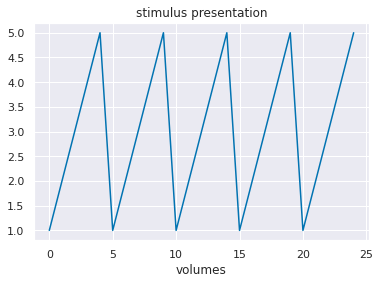

In [6]:
# Make an empty plot
plt.figure()

# Plot the data
plt.plot(volumes, labels)

# you can add plot title like this
plt.title('stimulus presentation')

# you can set xlabel like this
plt.xlabel('volumes');

In [7]:
label_dict = {1 : "target1", 2 : "target2", 3 : "target3", 4 : "target4", 5 : "target5"}

([<matplotlib.axis.XTick at 0x2aaad92acb00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

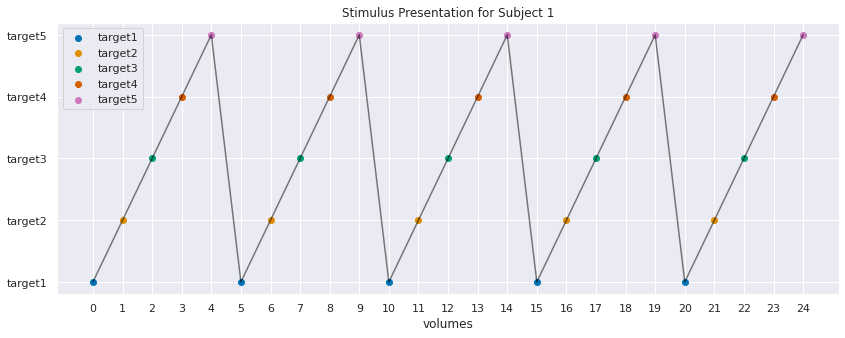

In [8]:
n_conditions = len(label_dict)
cur_pals = sns.color_palette('colorblind', n_colors=n_conditions)

# create a plotting panel 
f, ax = plt.subplots(1,1, figsize = (14, 5))

# plot the label for each condition
for i_cond in range(n_conditions): 
    label = list(label_dict.keys())[i_cond]
    temp_mask = label == labels
    ax.scatter(volumes[temp_mask], labels[temp_mask], 
               color = cur_pals[i_cond], marker = 'o')
ax.legend(label_dict.values())

# connect the dots 
ax.plot(volumes, labels, color = 'black', alpha = .5)

# mark the plot
ax.set_title('Stimulus Presentation for Subject %s' % (run_id))
ax.set_yticks(list(label_dict.keys()))
ax.set_yticklabels(label_dict.values())
ax.set_xlabel('volumes');
plt.xticks(volumes)

In [9]:
### load fmri data

In [10]:
epi_data = nib.load("/projects/csnl/shared/round_robin_bids/batch_data/derivatives/fmriprep/sub-G01S01/ses-wave1/func/sub-G01S01_ses-wave1_task-RR_acq-A_bold_space-MNI152NLin2009cAsym_preproc.nii.gz")
mask = nib.load("/projects/csnl/shared/round_robin_bids/batch_data/derivatives/fmriprep/sub-G01S01/ses-wave1/func/sub-G01S01_ses-wave1_task-RR_acq-A_bold_space-T1w_brainmask.nii.gz")

nifti_masker = NiftiMasker(mask_img=mask)
maskedData = nifti_masker.fit_transform(epi_data)

print('Data shape - before masking: ', epi_data.shape)
print('Data shape - after masking: ', maskedData.shape)

Data shape - before masking:  (97, 115, 97, 188)
Data shape - after masking:  (188, 218078)


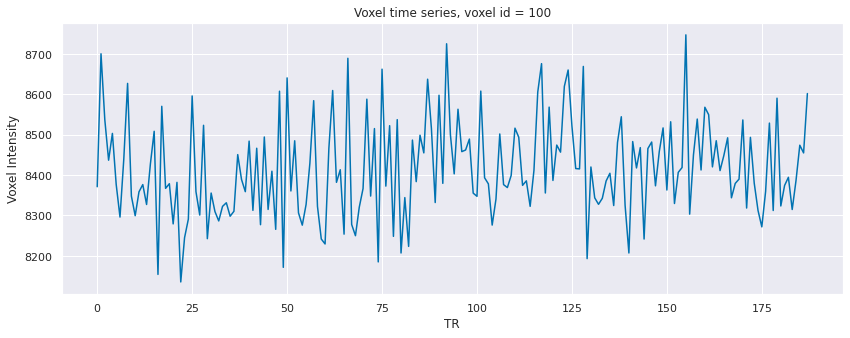

In [11]:
# Plot a voxel value (in this example of voxel 100) through time
voxel_id = 100

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(maskedData[:, voxel_id])

ax.set_title('Voxel time series, voxel id = %d' % voxel_id)
ax.set_xlabel('TR')
ax.set_ylabel('Voxel Intensity');

In [12]:
# The following procedure normalizes the response within voxels over time
scaler = preprocessing.StandardScaler().fit(maskedData)
maskedData_zscore = scaler.transform(maskedData)

#another way
scaler = preprocessing.StandardScaler()
scaler.fit(maskedData)
maskedData_zscore = scaler.transform(maskedData)

#yet another way
maskedData_zscore = preprocessing.StandardScaler().fit_transform(maskedData)


In [13]:
# checking the z score
voxel_mean = np.mean(maskedData_zscore, axis=0)
voxel_std = np.std(maskedData_zscore, axis=0)
print('The number of voxels in the mask is %d' % len(voxel_mean));
print('The mean of the first few voxels:\n', voxel_mean[0:4])
print('The std of the first few voxels:\n', voxel_std[0:4])

The number of voxels in the mask is 218078
The mean of the first few voxels:
 [ 3.6777333e-08 -4.2801208e-08  1.9656850e-08 -1.7754575e-08]
The std of the first few voxels:
 [0.9999999 0.9999999 1.0000001 1.       ]


(array([ 5., 11., 23., 46., 30., 30., 18., 14.,  7.,  4.]),
 array([-2.3084316 , -1.804495  , -1.3005582 , -0.79662156, -0.29268485,
         0.21125185,  0.71518856,  1.2191253 ,  1.7230619 ,  2.2269986 ,
         2.7309353 ], dtype=float32),
 <BarContainer object of 10 artists>)

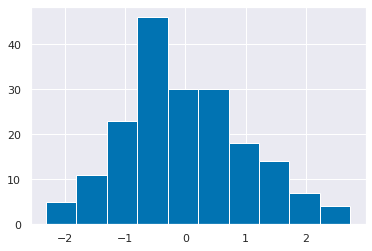

In [14]:
f, ax = plt.subplots(1,1)

ax.hist(maskedData_zscore[:,voxel_id])

In [15]:
### tutorial 3 classification
# define more study parameters
data_n_runs = 5
events, _ = data.shape
events_run = 72
TRs_run = int(events / data_n_runs)
stim_label_TR = np.zeros((TRs_run * data_n_runs, 1))

#stim_label_TR = np.array([data[0:,1]])
for i in range(events):
    stim_label_TR[i,] = data[i, 1]


Text(0.5, 0, 'Time in secs')

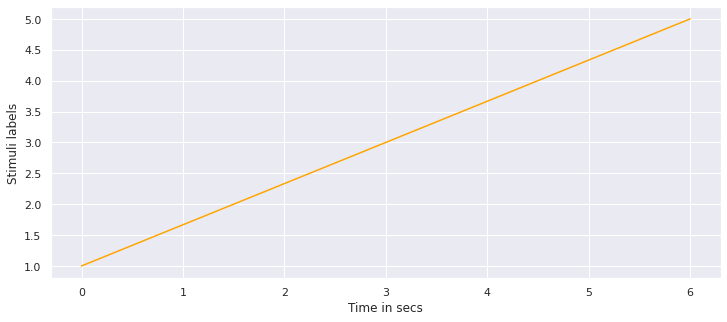

In [16]:
# Create a sequence of timepoints that a TR occurred on
time_points = np.arange(0, (TRs_run - 1) * 1.5 + 1, 1.5)

# Plot the data
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(time_points, stim_label_TR[0:TRs_run, 0], c='orange')

ax.set_ylabel('Stimuli labels')
ax.set_xlabel('Time in secs')

In [17]:
### hemodynamic response function -> to see hemodynamic lag
# To see the HRF, we will use a re-named function from fmrisim in BrainIAK
#help(hrf_func)

Text(0.5, 0, 'Time in secs')

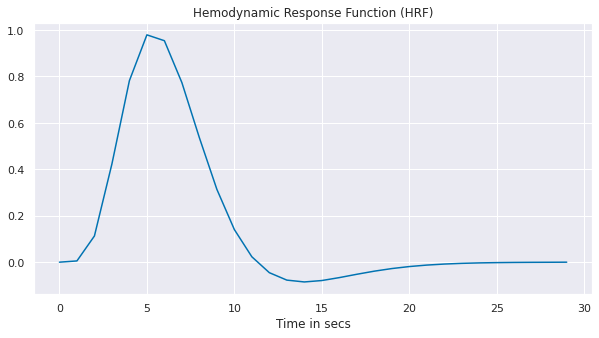

In [18]:
# Create an example HRF
hrf = hrf_func(temporal_resolution=1)

# Plot the canonical double gamma HRF
f, ax = plt.subplots(1,1, figsize = (10, 5))
ax.plot(range(30), hrf)

ax.set_title("Hemodynamic Response Function (HRF)")
ax.set_xlabel('Time in secs')

In [19]:
# Specify some parameters
trDuration = 2  # seconds
numTRs = 40 # How many TRs will you generate?
total_time = int(numTRs * trDuration)
temporal_res = 0.5 # 1/trDuration

In [20]:
# The event onsets at 20 seconds.
# The block lasts for 10 seconds (5 TRs).

stim_A = sim.generate_stimfunction(onsets=[20], 
                                   event_durations=[10], 
                                   total_time=total_time,
                                   temporal_resolution=temporal_res 
                                   )

Text(0.5, 0.98, 'Stimulus Timing: Block 10 s (5 TRs)')

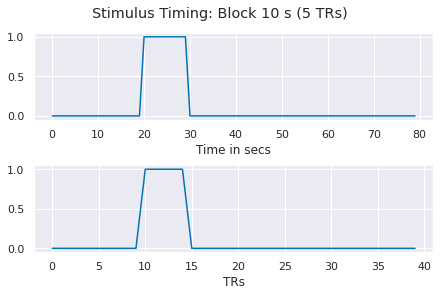

In [21]:
# Plot the design
fig, (ax0, ax1) = plt.subplots(nrows=2, constrained_layout=True)

ax0.plot(stim_A.repeat(trDuration))
ax0.set_xlabel('Time in secs')

ax1.plot(stim_A)
ax1.set_xlabel('TRs')

fig.suptitle('Stimulus Timing: Block 10 s (5 TRs)')

In [22]:
# Create the expected neural response
signal_func_A = sim.convolve_hrf(stimfunction=stim_A,
                                 tr_duration=trDuration,
                                 temporal_resolution=temporal_res,
                                 scale_function=1,
                                 )

Text(0.5, 0, 'TRs')

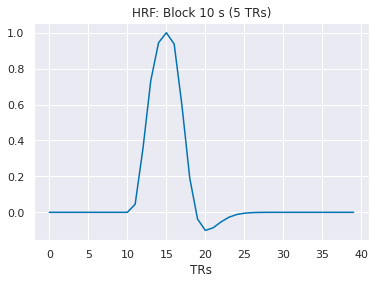

In [23]:
plt.plot(signal_func_A)
plt.title('HRF: Block 10 s (5 TRs)')
plt.xlabel('TRs')

In [24]:
# The events onset at 20 and 30 seconds
# Each event lasts for 2 seconds (1 TR)
stim_B = sim.generate_stimfunction(onsets=[20,28],
                                   event_durations=[2,2], 
                                   total_time=total_time,
                                   temporal_resolution=temporal_res,
                                  )

Text(0.5, 0, 'TRs')

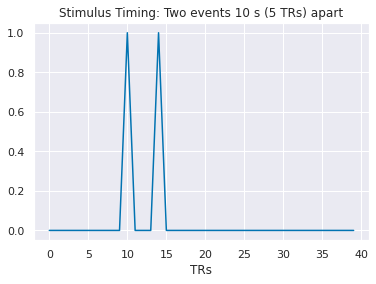

In [25]:
#Plot the design
plt.plot(stim_B)
plt.title('Stimulus Timing: Two events 10 s (5 TRs) apart')
plt.xlabel('TRs')

In [26]:
# Create the expected neural response
signal_func_B = sim.convolve_hrf(stimfunction=stim_B,
                                   tr_duration=2,
                                   temporal_resolution=temporal_res,
                                   scale_function=1,
                                   )

Text(0.5, 0, 'TRs')

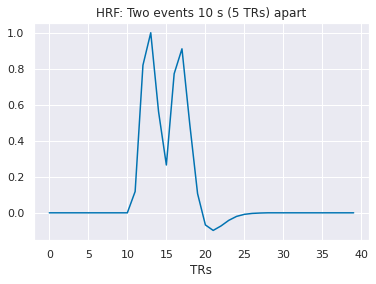

In [27]:
# Plot it
plt.plot(signal_func_B)
plt.title('HRF: Two events 10 s (5 TRs) apart')
plt.xlabel('TRs')

Text(0.5, 0, 'Time in secs')

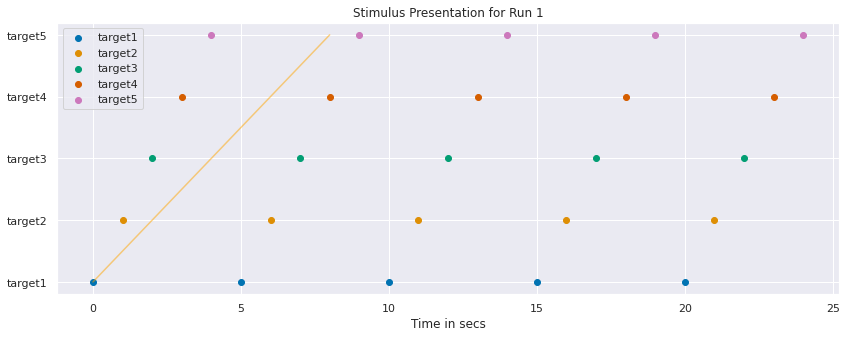

In [28]:
# time shift the data labels to account for HRF lag
n_conditions = len(label_dict)
cur_pals = sns.color_palette('colorblind', n_colors=n_conditions)

# Create a sequence of timepoints that a TR occurred on
tr_time = np.arange(0, (TRs_run - 1) * 2 + 1, 2)
time_vals = data[0:185, 0]
labels = data[0:185, 1]

f, ax = plt.subplots(1,1, figsize = (14, 5))
    
# plot the label for each condition
for i_cond in range(n_conditions): 
    label = list(label_dict.keys())[i_cond]
    temp_mask = label == labels
    ax.scatter(time_vals[temp_mask], labels[temp_mask], 
               color = cur_pals[i_cond], marker = 'o')
ax.legend(label_dict.values())
    
# plot the stimuli as a line 
# ax.plot(time_vals, labels, color = 'black', alpha = .5)
ax.plot(tr_time, stim_label_TR[0:TRs_run, 0], c='orange', alpha = .5)

ax.set_yticks(list(label_dict.keys()))
ax.set_yticklabels(label_dict.values())

ax.set_title('Stimulus Presentation for Run 1')
ax.set_xlabel('Time in secs')


In [29]:
# Shift the data a certain amount
hrf_lag = 4.5
TR = 2
print('Amount of time shift: %0.1f' % hrf_lag) # In seconds what is the lag between a stimulus onset and the peak bold response
shift_size = int(hrf_lag / TR)  # Convert the shift into TRs

# Create a function to shift the size
def shift_timing(label_TR, TR_shift_size):
    
    # Create a short vector of extra zeros
    zero_shift = np.zeros((TR_shift_size, 1))

    # Zero pad the column from the top
    label_TR_shifted = np.vstack((zero_shift, label_TR))

    # Don't include the last rows that have been shifted out of the time line
    label_TR_shifted = label_TR_shifted[0:label_TR.shape[0],0]
    
    return label_TR_shifted

# Apply the function
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

Amount of time shift: 4.5


ValueError: x and y must have same first dimension, but have shapes (5,) and (25,)

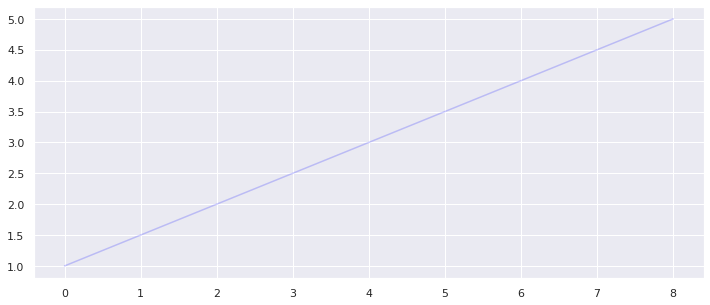

In [30]:
# Add the boxcar to the plot

f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(tr_time, stim_label_TR[0:TRs_run, 0], c='blue',alpha=0.2)
ax.plot(tr_time, stim_label_TR_shifted[0:185], c='orange')

ax.set_yticks(list(label_dict.keys()))
ax.set_yticklabels(label_dict.values())

ax.set_ylabel('Stimuli labels')
ax.set_xlabel('Time in secs')

plt.legend(['Original', 'Shifted'])

In [ ]:
# Searchlight begins here

In [32]:
from mpi4py import MPI
from sklearn.model_selection import PredefinedSplit
from sklearn.svm import LinearSVC
from scipy.stats import zscore
import os, sys
import pandas as pd
from nilearn.masking import compute_epi_mask

import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# Import libraries
import nibabel as nib
import numpy as np 
import time
from nilearn import plotting
from brainiak.searchlight.searchlight import Searchlight
from brainiak.fcma.preprocessing import prepare_searchlight_mvpa_data
from brainiak import io
from pathlib import Path
from shutil import copyfile

# Import machine learning libraries
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns 

# Set printing precision
np.set_printoptions(precision=2, suppress=True)

# %matplotlib inline 
%matplotlib notebook
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


In [33]:
def load_epi_data(sub):
    # Load MRI file (in Nifti format) of one localizer run
    epi_in = os.path.join(data_dir, "%s_merged.nii.gz" % (sub)) # iiiiii
    epi_data = nib.load(epi_in)
    print("Loading data from %s" % (epi_in))
    return epi_data

def shift_timing(label_TR, TR_shift_size):
    
    # Create a short vector of extra zeros
    zero_shift = np.zeros((TR_shift_size, 1))

    # Zero pad the column from the top
    label_TR_shifted = np.vstack((zero_shift, label_TR))

    # Don't include the last rows that have been shifted out of the time line
    label_TR_shifted = label_TR_shifted[0:label_TR.shape[0],0]
    
    return label_TR_shifted

In [34]:
sub = 'G01S01'
subject_name = 'G01S01'
#data_dir = "/projects/csnl/shared/round_robin_qc/analysis/preprocessed_data/sub-G01S01/ses-wave1/func/"
data_dir = "/projects/csnl/shared/round_robin_qc/analysis/no_st_qc/merged_sl/"
results_dir = "/projects/csnl/shared/round_robin_qc/analysis/braniak_tutorials/output/"
#mask_dir = "/projects/csnl/shared/round_robin_qc/analysis/braniak_tutorials/masks/"

epi_in = os.path.join(data_dir, "%s_merged.nii.gz" % (sub))
bold_data = nib.load(epi_in)
#mask_in = os.path.join(mask_dir, "NS_self_referential_3.1_MPFC.nii.gz")
#mask = nib.load(mask_in)

# remove all ITI (inter-trial intervals)
# onsets_ITI = pd.read_csv("/projects/csnl/shared/round_robin_qc/analysis/braniak_tutorials/G01S01_onsets_ITI.csv") # make sure we have onset files for everyone
# onsets_ITI = onsets_ITI.values
onsets = pd.read_csv("/projects/csnl/shared/round_robin_qc/analysis/no_st_qc/sl_train_G01S01.csv")
onsets = onsets.values

# Shift the data a certain amount
#HRF = 4.5
#TR = 2
#shift_size = int(HRF / TR)  # Convert the shift into TRs)  
n_runs = 5

# Convert the timing into TR indexes
'''
events, _ = onsets.shape
events_run = 72
TRs_run = int(events / n_runs)
stim_label_TR = np.zeros((TRs_run * n_runs, 1))
for i in range(events):
    stim_label_TR[i,] = onsets[i, 1]
    
    # Shift the data some amount
label = shift_timing(stim_label_TR, shift_size)
'''

# Load run_ids
run_ids = onsets[:,2] - 1
print(run_ids)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4]


In [35]:
# Pull out the MPI information
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size

In [36]:
# Output data Path
output_path = os.path.join(results_dir,'searchlight_results')
if rank == 0:
    if not os.path.exists(output_path):
        os.makedirs(output_path)

In [37]:
mask = mask.get_fdata()
coords = np.where(mask)

In [38]:
'''
# extract non-zero labels
label_index = np.squeeze(np.nonzero(label))
# Pull out the indexes
labels = labels[label_index]
'''

In [54]:
# Load targets
labels = onsets[:,1] - 1

# Split data according to run ids # TODO fix
ps = PredefinedSplit(run_ids)

# Same them as the broadcast variables
bcvar = [labels, ps]

In [55]:
bcvar

[array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
        2, 3, 4]),
 PredefinedSplit(test_fold=array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4]))]

In [53]:
# Load the data in rank 0
if rank == 0:
    # Make a function to load the data for one subject's merge file
    def load_data(directory, subject_name):
        epi_data = load_epi_data(subject_name)
        print(("Finished load sub %s" % (subject_name)))
        bold_data = epi_data.get_data()
        print(("Finished getdata sub %s" % (subject_name)))
        print(bold_data.shape)
        affine_mat = epi_data.affine
        print(("Finished affine sub %s" % (subject_name)))
        dimsize = epi_data.header.get_zooms()
        print(("Finished dim sub %s" % (subject_name)))
        return bold_data, affine_mat, dimsize
        
    data, affine_mat, dimsize = load_data(data_dir, sub)
    print(data.shape)
    # extract bold data for non-zero labels
    #data = data[:, :, :, label_index]
    '''
    # normalize the data within each run
    for r in range(n_runs):
        data[:, :, :, run_ids==r] = np.nan_to_num(zscore(data[:, :, :, run_ids==r], axis=3))
    '''
else:
    data = None

Loading data from /projects/csnl/shared/round_robin_qc/analysis/no_st_qc/merged_sl/G01S01_merged.nii.gz
Finished load sub G01S01
Finished getdata sub G01S01
(104, 104, 72, 25)
Finished affine sub G01S01
Finished dim sub G01S01
(104, 104, 72, 25)


In [41]:
#data.ndim

In [42]:
#small_mask = np.zeros(whole_brain_mask.shape)
#small_mask[30, 31, 13] = 1

# Set parameters
sl_rad = 1
max_blk_edge = 5
pool_size = 1

# Start the clock to time searchlight
begin_time = time.time()

# Create the searchlight object
sl = Searchlight(sl_rad=sl_rad,max_blk_edge=max_blk_edge)
print("Setup searchlight inputs")
print("Input data shape: " + str(data.shape))
print("Input mask shape: " + str(mask.shape) + "\n")

# Distribute the information to the searchlights (preparing it to run)
sl.distribute([data], mask)

# Broadcast variables
sl.broadcast(bcvar)

Setup searchlight inputs
Input data shape: (104, 104, 72, 25)
Input mask shape: (74, 90, 76)



In [43]:
# Set up the kernel function, in this case an SVM
def calc_svm(data, sl_mask, myrad, bcvar):
    if np.sum(sl_mask) < 14:
        return -1
    scores = []
    labels, ps = bcvar[0], bcvar[1]

    # Reshape the data
    sl_num_vx = sl_mask.shape[0] * sl_mask.shape[1] * sl_mask.shape[2]
    num_epoch = data[0].shape[3]
    data_sl = data[0].reshape(sl_num_vx, num_epoch).T

    # Classifier: loop over all runs to leave each run out once
    model = LinearSVC()
    for train_index, test_index in ps.split():
        X_train, X_test = data_sl[train_index], data_sl[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        # Fit a svm
        model.fit(X_train, y_train)
        # Calculate the accuracy for the hold out run
        score = model.score(X_test, y_test)
        scores.append(score)
        
    return np.mean(scores)

In [44]:
# Run the searchlight analysis
print("Begin SearchLight in rank %s\n" % rank)
sl_result = sl.run_searchlight(calc_svm, pool_size=pool_size)
print("End SearchLight in rank %s\n" % rank)

# Only save the data if this is the first core
if rank == 0:
    # Convert NaN to 0 in the output
    sl_result = np.nan_to_num(sl_result[mask==1])
    # Reshape
    result_vol = np.zeros((mask.shape[0], mask.shape[1], mask.shape[2]))  
    result_vol[coords[0], coords[1], coords[2]] = sl_result   
    # Convert the output into what can be used
    result_vol = result_vol.astype('double')   
    # Save the average result
    output_name = os.path.join(output_path, '%s_MPFC_SL.nii.gz' % (sub))
    sl_nii = nib.Nifti1Image(result_vol, affine_mat)
    hdr = sl_nii.header
    hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2]))
    nib.save(sl_nii, output_name)  # Save    
    
    print('Finished searchlight')
    end_time = time.time()
    print('Total searchlight duration (including start up time): %.2f' % (end_time - begin_time))

Begin SearchLight in rank 0



IndexError: invalid index to scalar variable.

In [ ]:
# then adapt to run across all subjects!